In [1]:
"""
CREATED FROM COMBINING RESEARCH FROM:

https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

and credits for how to create a VARMA model as well

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

"""

'\nCREATED FROM COMBINING RESEARCH FROM:\n\nhttps://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/\nhttps://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/\n\nand credits for how to create a VARMA model as well\n\nhttps://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/\n\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from pmdarima import auto_arima
from sklearn import metrics

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

#14 import statements

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#3 lines written by me

In [4]:
def format_data(path):
    df = pd.read_excel(path, index_col='Year', parse_dates=True)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    return df2

#6 lines total, 5 written by me, 1 reused from stackoverflow

In [5]:
#Handle missing data using mean imputation. Cannot use linear imputation as not always
#2 adjacent points are known

def fillmissing(data):
        
    newdata = data.fillna(data.mean())
    
    return newdata

#3 lines written by me

In [6]:
#Using Feature Importance to select best influences

"""
Modified from the guide:

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
"""

def feature_selection(model, X_train, X_test, y_train):
    
    selector = SelectFromModel(model, max_features=3, threshold=-np.inf)
    selector.fit (X_train, y_train)
    
    select_X_train = selector.transform(X_train)
    select_X_test = selector.transform(X_test)
    
    #print (selector.get_feature_names_out())
    
    selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=1, learning_rate = 0.1)
    selection_model.fit(select_X_train, y_train)
    
    select_y_pred = selection_model.predict(select_X_test)
    
    selection_model.get_booster().feature_names = selector.get_feature_names_out().tolist()
    plot_importance(selection_model.get_booster())
    
    return selector ,select_X_train ,select_y_pred

#11 lines of code taken from a guide and then modified

In [7]:
"""
CREDITS FOR IDEA OF USING AUTO-ARIMA IN CONJUCTION WITH VARMA GOES TO:

https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
"""

def stepwisefits(data, name=""):
    stepwise_fit = auto_arima(data, trace=True, suppress_warnings=True)
    
    print(f'{name} best')
    stepwise_fit.summary()
    
#4 lines from youtubte guide

In [8]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#16 lines total, 9 lines me, 3 lines modified, 3 lines documentation

In [9]:
data = format_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Multivariate More.xlsx')
data.drop(data.tail(1).index,inplace=True) #remove last row
filled_data = fillmissing(data)

In [10]:
X = filled_data.drop(columns=['GDP growth (annual %)'])
y = filled_data['GDP growth (annual %)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [11]:
#Using the hyperparameter tuned model for XGB

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=1, learning_rate=0.2)
model.fit(X_train, y_train, verbose=False)

#2 lines from documentation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

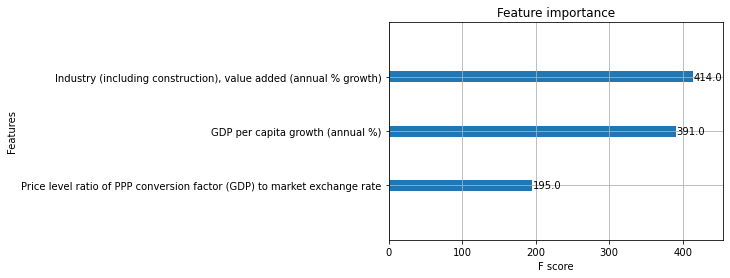

In [12]:
selector, select_X_train, select_y_pred = feature_selection(model, X_train, X_test, y_train)

#1 line written by me

In [13]:
best_indicators = filled_data[['GDP growth (annual %)', 
                               'General government final consumption expenditure (% of GDP)',
                              'Final consumption expenditure (% of GDP)',
                              'Foreign direct investment, net inflows (% of GDP)',
                              'Foreign direct investment, net outflows (% of GDP)',
                              'Exports of goods and services (% of GDP)', 
                               'Imports of goods and services (% of GDP)']]

#1 line written by me

In [14]:
#Using the plot above, select columns for multivariate forecast and join with gdp growth
featurenames = selector.get_feature_names_out().tolist()
selected_data = filled_data[featurenames]
gdp_data = pd.DataFrame(y)
joined_data = pd.concat([selected_data, gdp_data], axis=1)

#5 lines written by me

In [15]:
"""
Method for this way of checking for stationarity comes from and refactored from the guide:

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
"""
#Check stationarity
coint_johansen(best_indicators, -1,1).eig

#1 line from guide

array([0.57067771, 0.36245415, 0.25390001, 0.19118498, 0.17541883,
       0.08048844, 0.02371741])

In [16]:
#Split into train test
test_size = len(best_indicators) - int(len(best_indicators) * 0.8)
train = best_indicators[:int(len(best_indicators)*0.8)]
test = best_indicators[int(len(best_indicators)*0.8):]

#3 lines from guide but modified

In [17]:
for name, column in train.iteritems():
    stepwisefits(column, name=column.name)
    
#2 lines modified from guide

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=266.509, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=264.510, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=260.618, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=260.861, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=315.927, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=262.585, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=262.572, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=264.550, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=273.762, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.169 seconds
GDP growth (annual %) best
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=163.955, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=193.627, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=161.001, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] interc

In [18]:
#Create VARMA model
model_V = VARMAX(train, order=(1,0))
model_fit = model_V.fit(disp=False)
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

#3 lines from documentation and youtube vid together

In [19]:
df_pred = pd.DataFrame(y_pred)
df2 = df_pred['GDP growth (annual %)']
test_gdp = test['GDP growth (annual %)']

RMSE:  0.5540838192206987
MAPE:  8.85203071133509
MAE:  0.4749526023637937
Scatter Index:  10.260210903618516
MDA:  0.45454545454545453
Mean of actual:  5.400316079519256


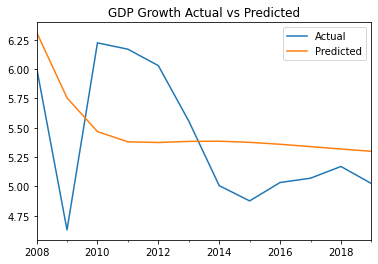

In [20]:
df_compare = pd.DataFrame({'Actual' : test_gdp, 'Predicted' : df2})
df_compare.plot(title='GDP Growth Actual vs Predicted')
performance_metrics(test_gdp, df2)

#3 lines written by me

In [21]:
"""86 Lines of code"""

'86 Lines of code'